### Init training pipeline with new models

#### Sub-modules 
- [har-imu-transformer](https://github.com/yolish/har-with-imu-transformer/tree/main)
- [sgn skeleton encoder](https://github.com/microsoft/SGN/tree/master)
- custom skeleton decoder

#### Training
- train with matching and non-matching IMU and skeleton pairs
- 


In [1]:
import os 
import sys
from datetime import date, datetime
from tqdm import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import json
import pickle
from collections import defaultdict, OrderedDict
# import neptune

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

sys.path.append('../')
from src.datasets.data import PAMAP2Reader, PAMAP2ReaderV2
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.utils.losses import *
from src.utils.analysis import action_evaluator


In [2]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [3]:
os.system('CUDA_LAUNCH_BLOCKING=1')

1

---
Data Load

In [4]:
data_root = 'G:/FYP/Codebases/Pose-AE/data'

In [5]:
dataReader = PAMAP2ReaderV2(data_root+'/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\DUET\notebooks\..\src\datasets\data.py:1275: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [6]:
skeleton_data = np.load(data_root+'/skeleton_k10_movements.npz')
skeleton_classes, skeleton_mov = skeleton_data['arr_0'], skeleton_data['arr_1']

print(skeleton_mov.shape)
print(np.unique(skeleton_classes, return_counts=True))
print(dataReader.label_map)
print(np.unique(skeleton_classes, return_counts=True))

(180, 60, 36)
(array(['Nordic walking', 'ascending stairs', 'car driving',
       'computer work', 'cycling', 'descending stairs', 'folding laundry',
       'house cleaning', 'ironing', 'lying', 'playing soccer',
       'rope jumping', 'running', 'sitting', 'standing',
       'vacuum cleaning', 'walking', 'watching TV'], dtype='<U17'), array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10], dtype=int64))
[(1, 'lying'), (2, 'sitting'), (3, 'standing'), (4, 'walking'), (5, 'running'), (6, 'cycling'), (7, 'Nordic walking'), (9, 'watching TV'), (10, 'computer work'), (11, 'car driving'), (12, 'ascending stairs'), (13, 'descending stairs'), (16, 'vacuum cleaning'), (17, 'ironing'), (18, 'folding laundry'), (19, 'house cleaning'), (20, 'playing soccer'), (24, 'rope jumping')]
(array(['Nordic walking', 'ascending stairs', 'car driving',
       'computer work', 'cycling', 'descending stairs', 'folding laundry',
       'house cleaning', 'ironing', 'lying', 'playin

In [7]:
skeleton_mov.shape

(180, 60, 36)

In [8]:
action2label = {i:j for i,j in enumerate(dataReader.idToLabel)}
action2label

{0: 'lying',
 1: 'sitting',
 2: 'standing',
 3: 'walking',
 4: 'running',
 5: 'cycling',
 6: 'Nordic walking',
 7: 'watching TV',
 8: 'computer work',
 9: 'car driving',
 10: 'ascending stairs',
 11: 'descending stairs',
 12: 'vacuum cleaning',
 13: 'ironing',
 14: 'folding laundry',
 15: 'house cleaning',
 16: 'playing soccer',
 17: 'rope jumping'}

In [9]:
dataReader.idToLabel

['lying',
 'sitting',
 'standing',
 'walking',
 'running',
 'cycling',
 'Nordic walking',
 'watching TV',
 'computer work',
 'car driving',
 'ascending stairs',
 'descending stairs',
 'vacuum cleaning',
 'ironing',
 'folding laundry',
 'house cleaning',
 'playing soccer',
 'rope jumping']

In [10]:
class_hierarchy = {
    'static activities': ['lying', 'sitting', 'standing'],
    'walking activities': ['walking', 'Nordic walking', 'ascending stairs', 'descending stairs'],
    'house chores': ['vacuum cleaning', 'ironing', 'folding laundry', 'house cleaning'],
    'sports': ['running', 'cycling', 'playing soccer', 'rope jumping'],
    'sitting activities': ['watching TV', 'computer work', 'car driving']
}

In [11]:
super_class = {}
for i,j in class_hierarchy.items():
    for c in j:
        super_class[c] = i 

In [12]:
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]
unseen1 = fold_classes[0]

In [13]:
drop_hierarchy = defaultdict(list)
for i in unseen1:
    drop_hierarchy[super_class[i]].append(i)


In [14]:
active_hierarchy = {i:list(set(j)-set(drop_hierarchy[i])) for i,j in class_hierarchy.items()}
active_hierarchy

{'static activities': ['lying', 'sitting'],
 'walking activities': ['walking', 'descending stairs', 'Nordic walking'],
 'house chores': ['ironing', 'vacuum cleaning', 'folding laundry'],
 'sports': ['rope jumping', 'cycling', 'playing soccer', 'running'],
 'sitting activities': ['computer work', 'car driving']}

In [15]:
data_dict = dataReader.generate(unseen_classes=[0,1,2,3,4,5], seen_ratio=0.8, unseen_ratio=0.1, window_size=12, window_overlap=10, resample_freq=50)

In [16]:
class BaseDataset(Dataset):
    def __init__(self, imu_data, imu_actions, skel_data, skel_label, action2label, active_cls, class_hierarchy, skel_len=120):
        super(BaseDataset, self).__init__()
        self.imu_data = torch.from_numpy(imu_data)
        self.imu_actions = imu_actions
        new_fts = [i for i in range(skel_data.shape[-1]) if i%3 != 2]
        self.skel_data = torch.from_numpy(skel_data[:, :skel_len, new_fts])
        self.skel_label = skel_label
        self.action2label = action2label
        # build action to id mapping dict
        self.skel_len = skel_len
        self.active_cls = active_cls
        self.class_hierarchy = class_hierarchy

        self.n_action = len(self.active_cls)
        self.action2Id = dict(zip(active_cls, range(self.n_action)))
        self.Id2action = dict(zip(range(self.n_action), active_cls))
        self.super2Id = dict(zip(class_hierarchy.keys(), range(len(class_hierarchy))))
        self.__setup_skel_dict()
        self.__setup_super()
        self.__update_hierarchy()
    
    def __setup_skel_dict(self):
        action_dict = defaultdict(list)
        for i, c in enumerate(self.skel_label):
            if c in self.active_cls:
                action_dict[c].append(self.skel_data[i])
        
        self.skel_dict = action_dict #{i: np.array(j) for i,j in action_dict.items()}

    def __get_skel(self, lbl_ind):
        lbl = self.Id2action[lbl_ind]
        ind = random.randint(0, 10) # has to update
        skel = self.skel_dict[lbl][ind]
        return skel 
        
    def __setup_super(self):
        super_class = {}
        classes = []
        for i,j in self.class_hierarchy.items():
            for c in j:
                classes.append(c)
                super_class[c] = i 
        
        self.super_class = super_class 
        self.all_classes = classes
        print(self.super_class)

    def __update_hierarchy(self):
        self.active_hierarchy = defaultdict(list)
        for c in self.active_cls:
            self.active_hierarchy[self.super_class[c]].append(c)

    def __get_hierarchy(self, class_name):
        super_class = self.super_class[class_name]
        classes = self.active_hierarchy[super_class]
        return super_class, classes.copy()

    def __getitem__(self, ind):
        x = self.imu_data[ind, ...]
        anchor_action = self.imu_actions[ind]
        anchor_label = self.action2label[anchor_action]
        anchor_y = self.action2Id[anchor_label]
        
        super_label, siblings = self.__get_hierarchy(anchor_label)
        # print(super_label, siblings)
        super_y = self.super2Id[super_label]
        # print(siblings, anchor_label)
        siblings.remove(anchor_label)
        neg_label = random.choice(siblings)
        neg_y = self.action2Id[neg_label]

        anchor_skel = self.__get_skel(anchor_y)
        neg_skel = self.__get_skel(neg_y)
        return x, super_y, anchor_y, neg_y, anchor_skel, neg_skel

    def __len__(self):
        return self.imu_data.shape[0]


In [17]:
act_c = ['Nordic walking', 'watching TV', 'computer work', 'car driving', 'ascending stairs', 'descending stairs', 'vacuum cleaning', 'ironing', 'folding laundry', 'house cleaning', 'playing soccer', 'rope jumping']
# act_c = ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
dataset = BaseDataset(imu_data=data_dict['train']['X'], imu_actions=data_dict['train']['y'], skel_data=skeleton_mov, skel_label=skeleton_classes, action2label=action2label, active_cls=act_c, class_hierarchy=class_hierarchy, skel_len=60)


{'lying': 'static activities', 'sitting': 'static activities', 'standing': 'static activities', 'walking': 'walking activities', 'Nordic walking': 'walking activities', 'ascending stairs': 'walking activities', 'descending stairs': 'walking activities', 'vacuum cleaning': 'house chores', 'ironing': 'house chores', 'folding laundry': 'house chores', 'house cleaning': 'house chores', 'running': 'sports', 'cycling': 'sports', 'playing soccer': 'sports', 'rope jumping': 'sports', 'watching TV': 'sitting activities', 'computer work': 'sitting activities', 'car driving': 'sitting activities'}


In [18]:
np.unique(data_dict['train']['y'])

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [19]:
dl =  DataLoader(dataset, batch_size=32, shuffle=True, pin_memory=True, drop_last=True)

In [20]:
for xi,si,yi,yni,skeli,skelni in dl:
    print(xi.shape, si.shape, yi.shape, yni.shape, skeli.shape, skelni.shape)
    print(yi)
    break

torch.Size([32, 24, 54]) torch.Size([32]) torch.Size([32]) torch.Size([32]) torch.Size([32, 60, 24]) torch.Size([32, 60, 24])
tensor([ 2,  7,  2,  8,  7,  6,  7,  8,  4,  0,  7,  2,  2,  8,  1,  7,  5,  0,
         3,  6,  2,  6,  2,  2, 10,  6,  0,  2,  5, 11,  2,  9])


In [21]:
class UnseenDataset(Dataset):
    def __init__(self, imu_data, imu_actions, skel_data, skel_label, action2label, active_cls, skel_len=120):
        super(UnseenDataset, self).__init__()
        self.imu_data = torch.from_numpy(imu_data)
        self.imu_actions = imu_actions
        new_fts = [i for i in range(skel_data.shape[-1]) if i%3 != 2]
        self.skel_data = skel_data[:, :skel_len, new_fts]
        self.skel_label = skel_label
        self.action2label = action2label
        # build action to id mapping dict
        self.skel_len = skel_len
        self.active_cls = active_cls
        self.n_action = len(self.active_cls)
        self.action2Id = dict(zip(active_cls, range(self.n_action)))
        self.Id2action = dict(zip(range(self.n_action), active_cls))
        self.__setup_skel_dict()

    def __setup_skel_dict(self):
        action_dict = defaultdict(list)
        for i, c in enumerate(self.skel_label):
            if c in self.active_cls:
                action_dict[c] = self.skel_data[i]
        
        self.skel_dict = action_dict
        self.skel_anchor = torch.from_numpy(np.array([action_dict[i] for i in self.active_cls]))

    def __getitem__(self, ind):
        x = self.imu_data[ind, ...]
        anchor_action = self.imu_actions[ind]
        anchor_label = self.action2label[anchor_action]
        anchor_id = self.action2Id[anchor_label]
        
        return x, anchor_id, self.skel_anchor

    def __len__(self):
        return self.imu_data.shape[0]

In [22]:
unseen_cls = ['lying', 'sitting', 'standing', 'walking', 'running', 'cycling']
unseen_dt = UnseenDataset(imu_data=data_dict['test']['X'], imu_actions=data_dict['test']['y'], skel_data=skeleton_mov, skel_label=skeleton_classes, action2label=action2label, active_cls=unseen_cls, skel_len=60)

unseen_dl =  DataLoader(unseen_dt, batch_size=32, shuffle=True, pin_memory=True, drop_last=True)

In [23]:
for ux, uy, uskels in unseen_dl:
    print(ux.shape, uy.shape, uskels.shape)
    break

torch.Size([32, 24, 54]) torch.Size([32]) torch.Size([32, 6, 60, 24])


---
Model Building

In [24]:
import math

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader

from torch.optim import Adam
from torch.nn import MSELoss,L1Loss

from src.models.bidirectional_cross_attention import BidirectionalCrossAttention

In [25]:
class norm_data(nn.Module):
    def __init__(self, dim=3, joints=20):
        super(norm_data, self).__init__()

        self.bn = nn.BatchNorm1d(dim*joints)

    def forward(self, x):
        bs, c, num_joints, step = x.size()
        x = x.view(bs, -1, step)
        x = self.bn(x)
        x = x.view(bs, -1, num_joints, step).contiguous()
        return x

class embed(nn.Module):
    def __init__(self, dim=3, joint=20, hidden_dim=128, norm=True, bias=False):
        super(embed, self).__init__()

        if norm:
            self.cnn = nn.Sequential(
                norm_data(dim, joint),
                cnn1x1(dim, 64, bias=bias),
                nn.ReLU(),
                cnn1x1(64, hidden_dim, bias=bias),
                nn.ReLU(),
            )
        else:
            self.cnn = nn.Sequential(
                cnn1x1(dim, 64, bias=bias),
                nn.ReLU(),
                cnn1x1(64, hidden_dim, bias=bias),
                nn.ReLU(),
            )

    def forward(self, x):
        x = self.cnn(x)
        return x

class cnn1x1(nn.Module):
    def __init__(self, dim1 = 3, dim2 =3, bias = True):
        super(cnn1x1, self).__init__()
        self.cnn = nn.Conv2d(dim1, dim2, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.cnn(x)
        return x

class local(nn.Module):
    def __init__(self, dim1 = 3, dim2 = 3, bias = False):
        super(local, self).__init__()
        self.maxpool = nn.AdaptiveMaxPool2d((1, None))
        self.cnn1 = nn.Conv2d(dim1, dim1, kernel_size=(1, 3), padding=(0, 1), bias=bias)
        self.bn1 = nn.BatchNorm2d(dim1)
        self.relu = nn.ReLU()
        self.cnn2 = nn.Conv2d(dim1, dim2, kernel_size=1, bias=bias)
        self.bn2 = nn.BatchNorm2d(dim2)
        self.dropout = nn.Dropout2d(0.2)

    def forward(self, x1):
        x1 = self.maxpool(x1)
        x = self.cnn1(x1)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.cnn2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class gcn_spa(nn.Module):
    def __init__(self, in_feature, out_feature, bias = False):
        super(gcn_spa, self).__init__()
        self.bn = nn.BatchNorm2d(out_feature)
        self.relu = nn.ReLU()
        self.w = cnn1x1(in_feature, out_feature, bias=False)
        self.w1 = cnn1x1(in_feature, out_feature, bias=bias)


    def forward(self, x1, g):
        x = x1.permute(0, 3, 2, 1).contiguous()
        x = g.matmul(x)
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.w(x) + self.w1(x1)
        x = self.relu(self.bn(x))
        return x

class compute_g_spa(nn.Module):
    def __init__(self, dim1 = 64 *3, dim2 = 64*3, bias = False):
        super(compute_g_spa, self).__init__()
        self.dim1 = dim1
        self.dim2 = dim2
        self.g1 = cnn1x1(self.dim1, self.dim2, bias=bias)
        self.g2 = cnn1x1(self.dim1, self.dim2, bias=bias)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x1):

        g1 = self.g1(x1).permute(0, 3, 2, 1).contiguous()
        g2 = self.g2(x1).permute(0, 3, 1, 2).contiguous()
        g3 = g1.matmul(g2)
        g = self.softmax(g3)
        return g
    

class SGNEncoder(nn.Module):
    def __init__(self, num_joint, seg, hidden_size=128, output_size=512, bs=32, is_3d=True, train=True, bias=True, device='cpu'):
        super(SGNEncoder, self).__init__()

        self.dim1 = hidden_size
        self.dim_unit = hidden_size // 4 
        self.seg = seg
        self.num_joint = num_joint
        self.bs = bs

        if is_3d:
          self.spatial_dim = 3
        else:
          self.spatial_dim = 2

        if train:
            self.spa = self.one_hot(bs, num_joint, self.seg)
            self.spa = self.spa.permute(0, 3, 2, 1).to(device)
            self.tem = self.one_hot(bs, self.seg, num_joint)
            self.tem = self.tem.permute(0, 3, 1, 2).to(device)
        else:
            self.spa = self.one_hot(32 * 5, num_joint, self.seg)
            self.spa = self.spa.permute(0, 3, 2, 1).to(device)
            self.tem = self.one_hot(32 * 5, self.seg, num_joint)
            self.tem = self.tem.permute(0, 3, 1, 2).to(device)

        self.tem_embed = embed(self.seg, joint=self.num_joint, hidden_dim=self.dim_unit*4, norm=False, bias=bias)
        self.spa_embed = embed(num_joint, joint=self.num_joint, hidden_dim=self.dim_unit, norm=False, bias=bias)
        self.joint_embed = embed(self.spatial_dim, joint=self.num_joint, hidden_dim=self.dim_unit, norm=True, bias=bias)
        self.dif_embed = embed(self.spatial_dim, joint=self.num_joint, hidden_dim=self.dim_unit, norm=True, bias=bias)
        self.maxpool = nn.AdaptiveMaxPool2d([1, 1])
        self.cnn = local(self.dim1, self.dim1 * 2, bias=bias)
        self.compute_g1 = compute_g_spa(self.dim1 // 2, self.dim1, bias=bias)
        self.gcn1 = gcn_spa(self.dim1 // 2, self.dim1 // 2, bias=bias)
        self.gcn2 = gcn_spa(self.dim1 // 2, self.dim1, bias=bias)
        self.gcn3 = gcn_spa(self.dim1, self.dim1, bias=bias)
        self.fc = nn.Linear(self.dim1 * 2, output_size)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))

        nn.init.constant_(self.gcn1.w.cnn.weight, 0)
        nn.init.constant_(self.gcn2.w.cnn.weight, 0)
        nn.init.constant_(self.gcn3.w.cnn.weight, 0)


    def forward(self, input):
        
        # Dynamic Representation
        input = input.view((self.bs, self.seg, self.num_joint, self.spatial_dim))
        input = input.permute(0, 3, 2, 1).contiguous().to()
        dif = input[:, :, :, 1:] - input[:, :, :, 0:-1]
        dif = torch.cat([dif.new(self.bs, dif.size(1), self.num_joint, 1).zero_(), dif], dim=-1)
        # print(input.shape)
        # print("input :", input.get_device(), " dif : ", dif.get_device())
        pos = self.joint_embed(input)
        # print("pos : ", pos.get_device(), " tem : ", self.tem.get_device(), " spa : ", self.spa.get_device())
        tem1 = self.tem_embed(self.tem)
        spa1 = self.spa_embed(self.spa)
        dif = self.dif_embed(dif)
        dy = pos + dif
        # Joint-level Module
        input= torch.cat([dy, spa1], 1)
        g = self.compute_g1(input)
        input = self.gcn1(input, g)
        input = self.gcn2(input, g)
        input = self.gcn3(input, g)
        # Frame-level Module
        input = input + tem1
        input = self.cnn(input)
        output = self.maxpool(input)
        output = torch.flatten(output, 1)
        output = self.fc(output)
        # output_feat = torch.squeeze(input)
        # output_feat = output_feat.permute(0,2,1).contiguous()
        # output_feat = input
        return output

    def one_hot(self, bs, spa, tem):

        y = torch.arange(spa).unsqueeze(-1)
        y_onehot = torch.FloatTensor(spa, spa)

        y_onehot.zero_()
        y_onehot.scatter_(1, y, 1)

        y_onehot = y_onehot.unsqueeze(0).unsqueeze(0)
        y_onehot = y_onehot.repeat(bs, tem, 1, 1)

        return y_onehot

        

In [26]:
class IMUTransformerEncoder(nn.Module):

    def __init__(self, config):
        """
        config: (dict) configuration of the model
        """
        super().__init__()

        self.transformer_dim = config.get("transformer_dim")

        self.input_proj = nn.Sequential(nn.Conv1d(config.get("input_dim"), self.transformer_dim, 1), nn.GELU(),
                                        nn.Conv1d(self.transformer_dim, self.transformer_dim, 1), nn.GELU(),
                                        nn.Conv1d(self.transformer_dim, self.transformer_dim, 1), nn.GELU(),
                                        nn.Conv1d(self.transformer_dim, self.transformer_dim, 1), nn.GELU())

        self.window_size = config.get("window_size")
        self.encode_position = config.get("encode_position")
        encoder_layer = TransformerEncoderLayer(d_model = self.transformer_dim,
                                       nhead = config.get("nhead"),
                                       dim_feedforward = config.get("dim_feedforward"),
                                       dropout = config.get("transformer_dropout"),
                                       activation = config.get("transformer_activation"))

        self.transformer_encoder = TransformerEncoder(encoder_layer,
                                              num_layers = config.get("num_encoder_layers"),
                                              norm = nn.LayerNorm(self.transformer_dim))
        self.cls_token = nn.Parameter(torch.zeros((1, self.transformer_dim)), requires_grad=True)

        if self.encode_position:
            self.position_embed = nn.Parameter(torch.randn(self.window_size + 1, 1, self.transformer_dim))

        # num_classes =  config.get("num_classes")
        output_size = config.get("output_size")
        self.imu_head = nn.Sequential(
            nn.AvgPool2d((self.window_size,1)),
            nn.Linear(self.transformer_dim,  output_size),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(output_size, output_size)
        )
        self.sigmoid = nn.Sigmoid()

        # init
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, data):
        src = data  # Shape N x S x C with S = sequence length, N = batch size, C = channels

        # Embed in a high dimensional space and reshape to Transformer's expected shape
        src = self.input_proj(src.transpose(1, 2)).permute(2, 0, 1)

        # Prepend class token
        cls_token = self.cls_token.unsqueeze(1).repeat(1, src.shape[1], 1)
        src = torch.cat([cls_token, src])

        # Add the position embedding
        if self.encode_position:
            src += self.position_embed

        # Transformer Encoder pass
        target = self.transformer_encoder(src)

        # Class probability
        target = torch.squeeze(target.permute(1,0,2))
        # target = self.imu_head(target)
        target = torch.squeeze(self.imu_head(target))
        return target

def get_activation(activation):
    """Return an activation function given a string"""
    if activation == "relu":
        return nn.ReLU(inplace=True)
    if activation == "gelu":
        return nn.GELU()
    raise RuntimeError("Activation {} not supported".format(activation))

In [27]:
class ContrastHead(nn.Module):
  def __init__(self, embedding_size):
        super(ContrastHead, self).__init__()
        self.imu_head = nn.Sequential(
            # nn.AvgPool2d((window_size,1)),
            # nn.Linear(embedding_size,  hidden_size),
            # nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(embedding_size, 1),
            nn.Sigmoid()
        )

  def forward(self, x):
        output = torch.squeeze(self.imu_head(x))
        return output

In [28]:
class SuperHead(nn.Module):
  def __init__(self, embedding_size, num_classes):
        super(SuperHead, self).__init__()
        self.imu_head = nn.Sequential(
            # nn.AvgPool2d((window_size,1)),
            # nn.Linear(embedding_size,  hidden_size),
            # nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(embedding_size, num_classes),
            nn.Softmax(dim=-1)
        )

  def forward(self, x):
        output = self.imu_head(x)
        return output

In [29]:
class BiLSTMDecoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,device="cpu"):
        super(BiLSTMDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.device = device
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.seq_len = seq_len

        if bidirectional:
            self.input_linear = nn.Linear(self.embedding_size,4*self.hidden_size)
        else:
            self.input_linear = nn.Linear(self.embedding_size,2*self.hidden_size)

        # define LSTM layer
        self.layers = []
        # add lstm
        self.lstm = nn.LSTM(input_size = self.linear_filters[0], hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=True,
                            batch_first=bidirectional)

                        
        # add linear layers 
        if bidirectional:
            self.layers.append(nn.Linear(2*hidden_size,self.linear_filters[0]))
        else:
            self.layers.append(nn.Linear(hidden_size,self.linear_filters[0]))

        for __id,layer_in in enumerate(self.linear_filters):
            if __id == len(linear_filters)-1:
                self.layers.append(nn.Linear(layer_in,self.input_size))
            else:
                self.layers.append(nn.Linear(layer_in,self.linear_filters[__id+1]))

        self.net = nn.Sequential(*self.layers)

        
        

    def forward(self,encoder_hidden):
        """
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence
        """
        
        
        hidden_shape = encoder_hidden.shape
        encoder_hidden = self.input_linear(encoder_hidden)
        
        if self.bidirectional:
            hidden = encoder_hidden.view((-1,4,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h1,h2,c1,c2 = torch.unbind(hidden,0)
            h,c = torch.stack((h1,h2)),torch.stack((c1,c2))
            bs = h.size()[1]
        else:
            hidden = encoder_hidden.view((-1,2,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h,c = torch.unbind(hidden,0)
            bs = h.size()[1]
        
        dummy_input = torch.rand((bs,self.seq_len,self.hidden_size), requires_grad=True).to(self.device)
        
        lstm_out, self.hidden = self.lstm(dummy_input,(h,c))
        x = self.net(lstm_out)
        
        return x

In [30]:
class BaseModel(nn.Module):
    def __init__(self, config):
        super(BaseModel, self).__init__()
        self.device = config['device']
        self.imu_model = IMUTransformerEncoder(config['imu_config'])
        self.skel_encoder = SGNEncoder(**config['sgn_config'])
        self.skel_decoder = BiLSTMDecoder(**config['dec_config'])
        self.contrast_head = ContrastHead(**config['contrast_config'])
        self.super_head = SuperHead(**config['super_config'])
        self.lxmert_xlayer = BidirectionalCrossAttention(**config['xmert_config'])

        self.imu_mask = torch.ones((config['bs'], config['imu_len']), requires_grad=True).bool().to(self.device)
        self.skel_mask = torch.ones((config['bs'], config['skel_len']), requires_grad=True).bool().to(self.device)
        

    def forward(self, x_imu, x_skel):
        imu_feats = self.imu_model(x_imu)
        skel_feats = self.skel_encoder(x_skel)
        imu_feats = torch.unsqueeze(imu_feats, dim=1)
        skel_feats = torch.unsqueeze(skel_feats, dim=1)
        # print(f"imu_feats {imu_feats.shape} | skel_feats {skel_feats.shape}")
        imu_feats, skel_feats = self.lxmert_xlayer(imu_feats, skel_feats, mask=self.imu_mask, context_mask=self.skel_mask)
        # print(f"imu_feats {imu_feats.shape} | skel_feats {skel_feats.shape}")
        # skel_recon = self.skel_decoder(skel_feats)
        # imu_feats = torch.squeeze(imu_feats)
        # bin_output = torch.squeeze(self.fc_head(imu_feats))
        imu_feats = torch.squeeze(imu_feats)
        skel_feats = torch.squeeze(skel_feats)
        # print(f"imu_feats {imu_feats.shape} | skel_feats {skel_feats.shape}")
        contrast_out = self.contrast_head(imu_feats)
        super_out = self.super_head(imu_feats)

        skel_recon = self.skel_decoder(imu_feats)
        return contrast_out, super_out, skel_recon

In [31]:
imu_config = {
	"input_dim": 54,
    "window_size":24,
	"encode_position":True,
	"transformer_dim": 512,
	"nhead": 8,
	"num_encoder_layers": 6, 
	"dim_feedforward": 128, 
	"transformer_dropout": 0.1, 
	"transformer_activation": "gelu",
	"head_activation": "gelu",
    "baseline_dropout": 0.1,
	"batch_size": 32,
	"output_size": 512
}

sgn_config = {
    'num_joint': 12,
    'seg': 60,
    'hidden_size': 128,
    'output_size': 512,
    'train': True,
    'bs': 32,
    'is_3d': False
}

# dec_config = {
#     'seq_len': 60,
#     'input_size': 24,
#     'hidden_size': 256,
#     'num_layers': 2,
#     'bidirectional': True,
#     "embedding_size": 128,
#     "linear_filters":[128,256,512,1024],
# }

dec_config = {
    'seq_len': 60,
    'input_size': 24,
    'hidden_size': 256,
    'linear_filters': [128, 256],
    'embedding_size': 512,
    'num_layers': 1,
    # 'output_size': 24,
    'bidirectional': True,
    'device': 'cpu'
}

# seq_len, input_size, hidden_size, linear_filters, embedding_size:int, num_layers = 1, bidirectional=True, device='cpu'

contrast_config = {
    'embedding_size': 512
}

super_config = {
    'embedding_size': 512,
    'num_classes': 5
}

base_config = {
    'imu_config': imu_config,
    'sgn_config': sgn_config,
    'dec_config': dec_config,
    'contrast_config': contrast_config,
    'super_config': super_config,
    'device': 'cpu',
    'bs': 32,
    'imu_len': 1,
    'skel_len': 60,
    'ft_size': 512,
    'xmert_config': {
            'dim': 512,
            'heads': 8,
            'dim_head': 64,
            'context_dim': 512,   
    }
}
 
base_model = BaseModel(base_config)

In [32]:
imu_input = torch.randn([32, 24, 54])
skel_input = torch.randn([32, 60, 24])
con_out, sup_out, skel_out = base_model(imu_input, skel_input)
print(con_out.shape, sup_out.shape, skel_out.shape)

torch.Size([32]) torch.Size([32, 5]) torch.Size([32, 60, 24])


---
Training Pipeline

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [34]:
def train_step(model, dl, optimizer, loss_modules, loss_weights, device, phase='train', loss_alpha=0.7):
    model = model.train()

    with tqdm(dl, unit='batch', desc=phase) as tepoch:
        for batch in tepoch:
            x, super_y, anchor_y, neg_y, anchor_skel, neg_skel = batch 
            x = x.float().to(device)
            super_y = super_y.long().to(device)
            anchor_y = anchor_y.float().to(device)
            neg_y = neg_y.float().to(device)
            anchor_skel = anchor_skel.float().to(device)
            neg_skel = neg_skel.float().to(device)
            # print(f"X : {X.shape} | skel : {skel.shape}")

            optimizer.zero_grad()
            with torch.set_grad_enabled(phase=='train'):
                pos_bin, pos_mul, pos_recon = model(x, anchor_skel)
                neg_bin, neg_mul, neg_recon = model(x, neg_skel)
                # print("cls_prob : ", cls_prob.shape, " skel_recon :", skel_recon.shape)
            
            # multi-class classification 
            matching_super_loss = loss_modules['anchor_super'](pos_mul, super_y)
            non_matching_super_loss = loss_modules['neg_super'](neg_mul, super_y)
            # binary classification
            y = torch.ones_like(super_y).float().to(device)
            marginal_loss = loss_modules['marginal_loss'](pos_bin, neg_bin, y)
            # skeleton reconstruction 
            trp_marginal_loss = loss_modules['trp_marginal'](anchor_skel, pos_recon, neg_recon)
            # pos_recon_loss = loss_modules['ctc_loss']()

            loss = loss_weights['alpha']*(matching_super_loss+non_matching_super_loss) + loss_weights['beta']*trp_marginal_loss + marginal_loss

            if phase == 'train':
                loss.backward()
                optimizer.step()

            # for name, param in model.named_parameters():
            #     print(name, param.grad.max())

            metrics = {"loss": loss.item(), 'matching super class loss': matching_super_loss.item(), 'non matching super class loss': non_matching_super_loss.item(),
                       'matching marginal loss': marginal_loss.item(), 'reconstruction triplet marginal loss': trp_marginal_loss.item()}
            tepoch.set_postfix({"loss": loss.item()})
            # pred_class = cls_prob.cpu().detach().numpy()
            y_pred = (pos_bin.cpu().detach().numpy() >= 0.5).astype(int)
            # print("y_true : ", y.cpu().detach().numpy().astype(int), " y_pred : ", pred_class)
            metrics["accuracy"] = accuracy_score(y_true=y.cpu().detach().numpy().astype(int), y_pred=y_pred)
            
        return metrics 

In [35]:
def validate_step(model, dl, optimizer, loss_modules, loss_weights, device, class_names, phase='train', loss_alpha=0.7, print_report=False, show_plot=False):
    model = model.eval()
    per_batch = {'targets': [], 'bin_pred': [], 'super_pred': [], 'super_target': [], 'metrics': []}
    metrics = {"samples": 0, "loss": 0, 'matching super class loss': 0, 'non matching super class loss': 0,
                       'matching marginal loss': 0, 'reconstruction triplet marginal loss': 0}

    with tqdm(dl, unit='batch', desc=phase) as tepoch:
        for batch in tepoch:
            x, super_y, anchor_y, neg_y, anchor_skel, neg_skel = batch 
            x = x.float().to(device)
            super_y = super_y.long().to(device)
            anchor_y = anchor_y.float().to(device)
            neg_y = neg_y.float().to(device)
            anchor_skel = anchor_skel.float().to(device)
            neg_skel = neg_skel.float().to(device)
            # print(f"X : {X.shape} | skel : {skel.shape}")

            optimizer.zero_grad()
            with torch.set_grad_enabled(phase=='train'):
                pos_bin, pos_mul, pos_recon = model(x, anchor_skel)
                neg_bin, neg_mul, neg_recon = model(x, neg_skel)
                # print("cls_prob : ", cls_prob.shape, " skel_recon :", skel_recon.shape)
            
            # multi-class classification 
            matching_super_loss = loss_modules['anchor_super'](pos_mul, super_y)
            non_matching_super_loss = loss_modules['neg_super'](neg_mul, super_y)
            # binary classification
            y = torch.ones_like(super_y).float().to(device)
            marginal_loss = loss_modules['marginal_loss'](pos_bin, neg_bin, y)
            # skeleton reconstruction 
            trp_marginal_loss = loss_modules['trp_marginal'](anchor_skel, pos_recon, neg_recon)
            # pos_recon_loss = loss_modules['ctc_loss']()

            loss = loss_weights['alpha']*(matching_super_loss+non_matching_super_loss) + loss_weights['beta']*trp_marginal_loss + marginal_loss

            with torch.no_grad():
                metrics['samples'] += len(y)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['matching super class loss'] += matching_super_loss.item()
                metrics['non matching super class loss'] += non_matching_super_loss.item()
                metrics['matching marginal loss'] += marginal_loss.item()
                metrics['reconstruction triplet marginal loss'] += trp_marginal_loss.item()

            y_pred = (pos_bin.cpu().detach().numpy() >= 0.5).astype(int)
            per_batch['targets'].append(y.cpu().numpy())
            per_batch['bin_pred'].append(y_pred)
            per_batch['super_pred'].append(pos_mul.cpu().detach().numpy())
            per_batch['super_target'].append(super_y.cpu().detach().numpy())
            per_batch['metrics'].append([loss.detach().cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["bin_pred"])
    all_super_preds = np.concatenate(per_batch["super_pred"])
    all_targets = np.concatenate(per_batch["targets"])
    all_super_targets = np.concatenate(per_batch["super_target"])
    
    metrics["binary accuracy"] = accuracy_score(y_true=all_targets.astype(int), y_pred=all_preds)
    metrics_dict = action_evaluator(y_pred=np.argmax(all_super_preds,axis=1), y_true=all_super_targets.astype(int), class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [36]:
def unseen_eval(model, unseen_dl, device, class_names, print_report=True, show_plot=True):
    model = model.eval()
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': [], 'feat': []}
    metrics = {"samples": 0, "loss": 0, "recon. loss": 0, "classi. loss": 0}

    with tqdm(unseen_dl, unit='batch') as tepoch:
        for batch in tepoch:
            X, y, skels = batch 
            X = X.float().to(device)
            y = y.long()
            skels = skels.float().to(device)

        skels = skels.permute(1,0,2,3)
        preds = []
        for i in range(len(class_names)):
            with torch.no_grad():
                cls_prob, _, _ = model(X, skels[i, ...])
                preds.append(cls_prob.cpu().detach().numpy())
            
        preds = np.array(preds)
        # print("preds shape : ", preds.shape)
        per_batch['targets'].append(y.cpu().numpy())
        per_batch['predictions'].append(preds)

    all_preds = np.argmax(np.concatenate(per_batch["predictions"]).T, axis=-1)
    all_targets = np.concatenate(per_batch["targets"]).astype(int)
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets, class_names=class_names, print_report=print_report, show_plot=show_plot)

    return metrics_dict

In [37]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['matching super class loss'] = df['matching super class loss']/df['samples']
    df['non matching super class loss'] = df['non matching super class loss']/df['samples']
    df['matching marginal loss'] = df['matching marginal loss']/df['samples']
    df['reconstruction triplet marginal loss'] = df['reconstruction triplet marginal loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='matching super class loss', hue='phase', marker='o', ax=axs[0]).set(title="Matching Super-class Classification Loss")
    sns.lineplot(data=df, x='epoch', y='non matching super class loss', hue='phase', marker='o', ax=axs[0]).set(title="Non-matching Super-class Classification Loss")
    sns.lineplot(data=df, x='epoch', y='matching marginal loss', hue='phase', marker='o', ax=axs[1]).set(title="Matching Marginal binary loss")
    sns.lineplot(data=df, x='epoch', y='reconstruction triplet marginal loss', hue='phase', marker='o', ax=axs[1]).set(title="reconstruction triplet marginal loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Super class Accuracy")
    sns.lineplot(data=df, x='epoch', y='binary accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Binary Accuracy")

---
Run

In [38]:
config = {
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "Transfomer-Encder",
    "sem-space": 'I3D',
    # model training configs
    "lr": 0.00001,
    "loss_alpha": 0.1,
    "n_epochs": 3,
    "batch_size": 32,
    # model configs
    "feat_size": 512, # skel-AE hidden size and IMU-Anc output size
    # dataset configs
    "window_size": 12, 
    "overlap": 10,
    "freq": 50,
    "seq_len": 60,  # skeleton seq. length
    "seen_split": 0.1,
}

In [39]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [40]:
data_dict = dataReader.generate(unseen_classes=[1,2], seen_ratio=config['seen_split'], unseen_ratio=0.8, window_size=config['window_size'], window_overlap=config['overlap'], resample_freq=config['freq'])
dl =  DataLoader(dataset, batch_size=8, shuffle=True, pin_memory=True, drop_last=True)
for x,_, _, _ ,skel, _ in dl:
    _, seq_len, imu_feat = x.shape 
    _, timestamps, joints = skel.shape
    break

In [41]:
imu_config = {
	"input_dim": imu_feat, # 
    "window_size": seq_len, # 
	"encode_position":True,
	"transformer_dim": 256, ##
	"nhead": 8,
	"num_encoder_layers": 6, 
	"dim_feedforward": 128, 
	"transformer_dropout": 0.1, 
	"transformer_activation": "gelu",
	"head_activation": "gelu",
    "baseline_dropout": 0.1,
	"batch_size": 32,
	"output_size": config['feat_size'] ##
}

imuenc_config = {
    'in_ft': imu_feat,
    'd_model': 256,
    'ft_size': config['feat_size'],
    'num_heads': 2,
    'max_len': seq_len,
    'dropout': 0.1
}

sgn_config = {
    'num_joint': joints//2, #
    'seg': timestamps, #
    'hidden_size': config['feat_size']//2, 
    'train': True,
    'bs': config['batch_size'], ##
    'is_3d': False,
    'device': device
}

# dec_config = {
#     'seq_len': timestamps, #
#     'input_size': joints, #
#     'hidden_size': 256, 
#     'num_layers': 2,
#     'bidirectional': True,
#     "embedding_size": 128, ##
#     "linear_filters":[128,256,512,1024],
# }

dec_config = {
    'seq_len': timestamps,
    'input_size': joints,
    'hidden_size': 256,
    'num_layers': 1,
    'embedding_size': config['feat_size'],
    'linear_filters': [128, 256],
    # 'output_size': joints,
    'bidirectional': True,
    'device': device
}

contrast_config = {
    'embedding_size': 512
}

super_config = {
    'embedding_size': 512,
    'num_classes': 5
}

base_config = {
    'imu_config': imu_config,
    'sgn_config': sgn_config,
    'dec_config': dec_config,
    'contrast_config': contrast_config,
    'super_config': super_config,
    # 'num_layers': 1,
    'device': device,
    'bs': config['batch_size'],
    'imu_len': 1,
    'skel_len': timestamps,
    'ft_size': config['feat_size'],
    'xmert_config': {
        'dim': config['feat_size'],
        'heads': 4,
        'dim_head': 64,
        'context_dim': config['feat_size']#
    }
}



In [42]:
def log(fold, phase, metrics):
    for m, v in metrics.items():
        if fold == 'global':
            run[f'global/{m}'].log(v)
        else:
            run[f"Fold-{fold}/{phase}/{m}"].log(v) 

In [43]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  ['lying', 'sitting', 'walking', 'running', 'cycling', 'Nordic walking', 'computer work', 'car driving', 'descending stairs', 'vacuum cleaning', 'ironing', 'folding laundry', 'playing soccer', 'rope jumping']
unseen classes >  ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
Initiate IMU datasets ...
{'lying': 'static activities', 'sitting': 'static activities', 'standing': 'static activities', 'walking': 'walking activities', 'Nordic walking': 'walking activities', 'ascending stairs': 'walking activities', 'descending stairs': 'walking activities', 'vacuum cleaning': 'house chores', 'ironing': 'house chores', 'folding laundry': 'house chores', 'house cleaning': 'house chores', 'running': 'sports', 'cycling': 'sports', 'playing soccer': 'sports', 'rope jumping': 'sports', 'watching TV': 'sitting activities', 'computer work': 'sittin

Training Epoch:  33%|███▎      | 1/3 [03:34<07:09, 214.91s/it]

Overall accuracy: 0.335



Training Epoch:  67%|██████▋   | 2/3 [07:54<04:00, 240.95s/it]

Overall accuracy: 0.337



train: 100%|██████████| 31/31 [00:10<00:00,  2.86batch/s, loss=1.66]


Overall accuracy: 0.391



100%|██████████| 84/84 [00:00<00:00, 337.50batch/s]


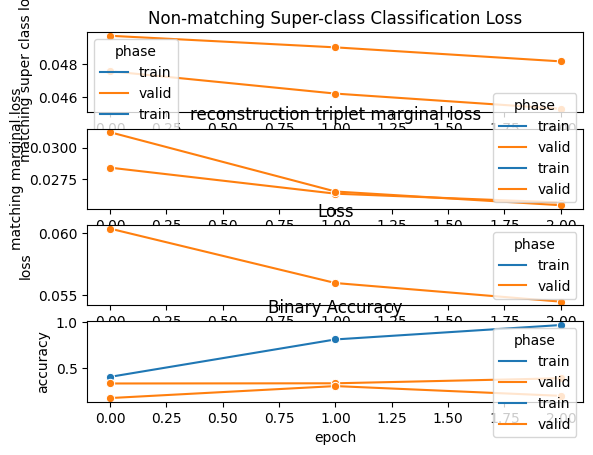

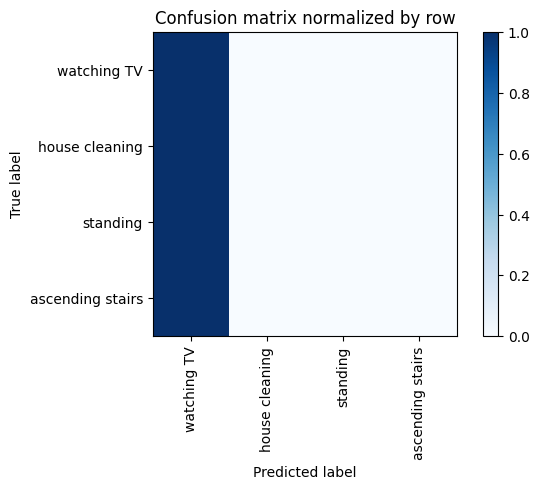

Overall accuracy: 0.156

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  house cleaning       0.000      0.000      0.000      0.375         12|	 watching TV: 1.000,	ascending stairs: 0.000,	standing: 0.000,	
        standing       0.000      0.000      0.000      0.312         10|	 watching TV: 1.000,	ascending stairs: 0.000,	
ascending stairs       0.000      0.000      0.000      0.156          5|	 watching TV: 1.000,	standing: 0.000,	
     watching TV       0.156      1.000      0.270      0.156          5|	 ascending stairs: 0.000,	standing: 0.000,	

----------------------------------------------------------------------------------------------------
     avg / total       0.024      0.156      0.042        1.0         32|	      

{'accuracy': 0.15625, 'precision': 0.0390625, 'recall': 0.25, 'f1': 0.06756756756756757}
================ Fold-1 ================
Unseen Classes : ['walking', 'rope jumping', 'sitting', 'descending stairs']
se

train:   7%|▋         | 19/286 [00:13<03:07,  1.42batch/s, loss=1.95]


KeyboardInterrupt: 

In [44]:
# run['parameters'] = config
fold_metric_scores = []

for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=0.8, window_size=config['window_size'], window_overlap=config['overlap'], resample_freq=config['freq'])
    all_classes = dataReader.idToLabel
    seen_classes = [all_classes[i] for i in data_dict['seen_classes']]
    unseen_classes = [all_classes[i] for i in data_dict['unseen_classes']]
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    # train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = BaseDataset(imu_data=data_dict['train']['X'], imu_actions=data_dict['train']['y'], skel_data=skeleton_mov, skel_label=skeleton_classes, action2label=action2label, active_cls=seen_classes, class_hierarchy=class_hierarchy, skel_len=timestamps)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = BaseDataset(imu_data=data_dict['eval-seen']['X'], imu_actions=data_dict['eval-seen']['y'], skel_data=skeleton_mov, skel_label=skeleton_classes, action2label=action2label, active_cls=seen_classes, class_hierarchy=class_hierarchy, skel_len=timestamps)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = UnseenDataset(imu_data=data_dict['test']['X'], imu_actions=data_dict['test']['y'], skel_data=skeleton_mov, skel_label=skeleton_classes, action2label=action2label, active_cls=unseen_classes, skel_len=timestamps)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    model = BaseModel(base_config)
    model.to(device)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'])
    loss_modules = {'anchor_super': nn.CrossEntropyLoss(), 'neg_super': nn.CrossEntropyLoss(), 'marginal_loss': nn.MarginRankingLoss(margin=0.9), 'trp_marginal': nn.TripletMarginWithDistanceLoss(distance_function=nn.PairwiseDistance())}
    loss_weights = {'alpha': 0.2, 'beta': 0.4}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
    
        train_metrics = train_step(model, train_dl, optimizer, loss_modules, loss_weights, device, phase='train', loss_alpha=config['loss_alpha'])
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        # log(i, 'train', train_metrics)

        eval_metrics = validate_step(model, eval_dl, optimizer, loss_modules, loss_weights, device, seen_classes, phase='train', loss_alpha=config['loss_alpha'], print_report=False, show_plot=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        # log(i, 'valid', train_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    model.load_state_dict(best_model)
    # save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = unseen_eval(model, test_dl, device, unseen_classes, print_report=True, show_plot=True)
    fold_metric_scores.append(test_metrics)
    # log('test', i, test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
print(seen_score_df.mean())
# log('global', '',seen_score_df.mean().to_dict())
# run.stop()

In [ ]:
torch.cuda.empty_cache()